In [313]:
# Suprimir warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Data processing
# ==============================================================================
import yfinance as yf
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
from sklearn.preprocessing import StandardScaler
# Plots
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from skforecast.plot import set_dark_theme
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.plot import plot_residuals, calculate_lag_autocorrelation
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================

import xgboost
import lightgbm
import catboost
import sklearn
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from statsmodels.stats.diagnostic import acorr_ljungbox
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
    PolynomialFeatures,
)
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import skforecast
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    bayesian_search_forecaster,
    backtesting_forecaster,
)
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features
from skforecast.metrics import calculate_coverage

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')
from skforecast.exceptions import DataTransformationWarning

import copy
from sklearn.metrics import mean_squared_error

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión lightgbm: {lightgbm.__version__}")
print(f"{color}Versión xgboost: {xgboost.__version__}")
print(f"{color}Versión catboost: {catboost.__version__}")
print(f"{color}Versión numpy: {np.__version__}")


Versión skforecast: 0.19.1
Versión scikit-learn: 1.7.2
Versión lightgbm: 4.6.0
Versión xgboost: 3.1.3
Versión catboost: 1.2.8
Versión numpy: 2.2.6


In [314]:
df = pd.read_csv("base_enriquecida.csv")
df['d'] = pd.to_datetime(df['d'])
df = df.set_index('d')
df = df.sort_index()
df.head()

,reservas_musd,EMAE,IPC_VAR,Base_Monetaria,saldo comercial,Precio_Maiz,Precio_Trigo,Precio_Soja,Brecha_Usd,Tasa_Badlar,...,target_reservas_next_month,cepo,cosecha_gruesa,sequia,anio_electoral,cosecha_efectiva,desembolso_fmi,trimestre,es_diciembre,brecha_promedio_3m
d,,,,,,,,,,,,,,,,,,,,,
1998-12-31,32741.700000,101.335976,0.000,15460.750000,-247.22,92.717066,111.804587,204.912522,0.0,10.856250,...,33044.200000,0,0,0,0,0,0,4,1,NaN
1999-01-31,33044.200000,101.886715,0.005,15621.250000,-362.79,92.947012,111.893213,195.036666,0.0,10.856250,...,33319.550000,0,0,0,1,0,0,1,0,NaN
1999-02-28,33319.550000,102.420243,-0.002,14959.900000,-331.77,83.598403,104.278526,179.671672,0.0,8.893750,...,33503.130435,0,0,0,1,0,0,1,0,0.0
1999-03-31,33503.130435,102.050216,-0.008,14651.043478,-80.54,86.381915,104.575670,175.055284,0.0,6.804348,...,32526.600000,0,0,0,1,0,0,1,0,0.0
1999-04-30,32526.600000,100.518473,-0.001,14358.350000,160.97,87.120921,102.331112,177.535731,0.0,5.756250,...,31701.300000,0,1,0,1,1,0,2,0,0.0


In [315]:
# 1. Definir qué columnas queremos traer de afuera
cols_externas = ['DX-Y.NYB', 'FEDFUNDS', 'DGS10']

# 2. Limpieza preventiva: eliminamos las columnas si ya existen en el df 
# Esto evita el ValueError de "columns overlap"
df = df.drop(columns=[c for c in cols_externas if c in df.columns])

# 3. Descargas
start_date = '1998-01-01'

# Dollar Index
dxy = yf.download('DX-Y.NYB', start=start_date)['Close'].resample('ME').last()
dxy.name = 'DX-Y.NYB'

# Tasas de la FED y Treasury 10Y
fred_data = pdr.get_data_fred(['FEDFUNDS', 'DGS10'], start=start_date)
fred_data = fred_data.resample('ME').last()

# 4. Unión limpia
df = df.join(dxy).join(fred_data)

# 5. Cálculo de variables derivadas (Momentum y aceleración)
df['riesgo_pais_cambio'] = df['riesgo_pais'].diff()
df['riesgo_pais_aceleracion'] = df['riesgo_pais_cambio'].diff()

# Presión cambiaria y aceleración de brecha
df['brecha_cambio'] = df['Brecha_Usd'].diff()
df['brecha_acelerando'] = (df['brecha_cambio'] > df['brecha_cambio'].shift(1)).astype(int)

# Interacción económica
df['efecto_cosecha'] = df['cosecha_gruesa'].astype(int) * df['Precio_Soja']

print("¡Unión exitosa! Columnas actuales:", df.columns)

[*********************100%***********************]  1 of 1 completed


¡Unión exitosa! Columnas actuales: Index(['reservas_musd', 'EMAE', 'IPC_VAR', 'Base_Monetaria', 'saldo comercial',
       'Precio_Maiz', 'Precio_Trigo', 'Precio_Soja', 'Brecha_Usd',
       'Tasa_Badlar', 'riesgo_pais', 'Tasa de interes Internacional', 'VIX',
       'reservas_lag1', 'EMAE_lag1', 'target_reservas_next_month', 'cepo',
       'cosecha_gruesa', 'sequia', 'anio_electoral', 'cosecha_efectiva',
       'desembolso_fmi', 'trimestre', 'es_diciembre', 'brecha_promedio_3m',
       'DX-Y.NYB', 'FEDFUNDS', 'DGS10', 'riesgo_pais_cambio',
       'riesgo_pais_aceleracion', 'brecha_cambio', 'brecha_acelerando',
       'efecto_cosecha'],
      dtype='object')


In [316]:
#Indice y frecuencia
exog_cols = [col for col in df.columns if col != 'reservas_musd']
df.index = pd.to_datetime(df.index)


df = df.sort_index()


try:
    df = df.asfreq('ME')
except ValueError:
    df = df.asfreq('M')


print(f"Frecuencia del índice: {df.index.freq}")


Frecuencia del índice: <MonthEnd>


In [317]:
# Definicion de puntos de corte cronológicos
fin_train = '2018-12-31'
fin_validacion = '2021-12-31'

datos_train = df.loc[:fin_train, :]
datos_val   = df.loc[fin_train:fin_validacion, :]
datos_test  = df.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 1998-12-31 00:00:00 --- 2018-12-31 00:00:00  (n=241)
Fechas validación : 2018-12-31 00:00:00 --- 2021-12-31 00:00:00  (n=37)
Fechas test       : 2021-12-31 00:00:00 --- 2025-10-31 00:00:00  (n=47)


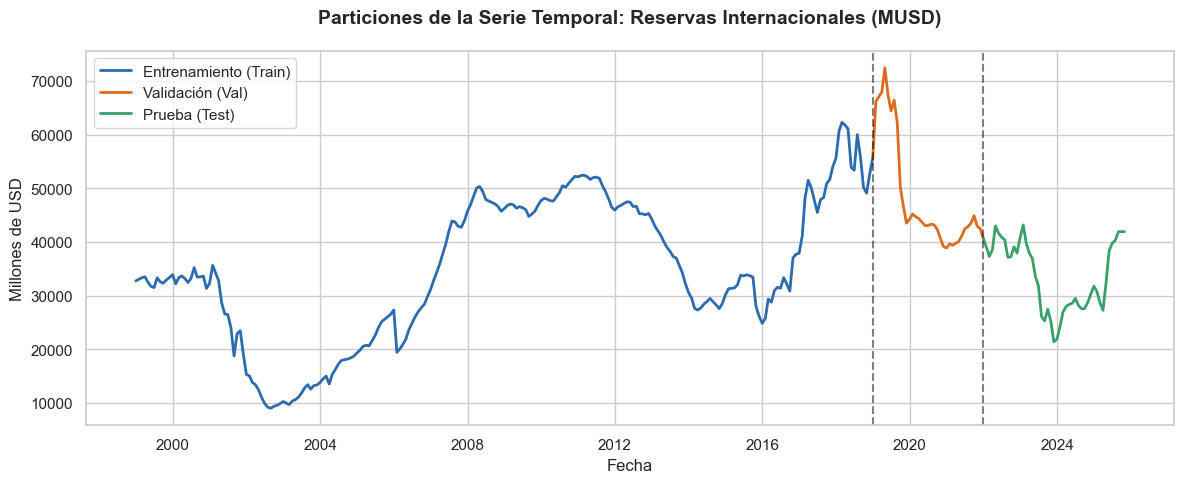

In [318]:
# Fondo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))

# Color de cada particion
plt.plot(datos_train.index, datos_train['reservas_musd'], label='Entrenamiento (Train)', color='#2b6cb0', linewidth=2)
plt.plot(datos_val.index, datos_val['reservas_musd'], label='Validación (Val)', color='#dd6b20', linewidth=2)
plt.plot(datos_test.index, datos_test['reservas_musd'], label='Prueba (Test)', color='#38a169', linewidth=2)

# Lineas verticales
plt.axvline(pd.to_datetime(fin_train), color='black', linestyle='--', alpha=0.5)
plt.axvline(pd.to_datetime(fin_validacion), color='black', linestyle='--', alpha=0.5)

# Títulos y etiquetas
plt.title('Particiones de la Serie Temporal: Reservas Internacionales (MUSD)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Millones de USD', fontsize=12)
plt.legend(frameon=True, loc='upper left')

plt.tight_layout()
plt.show()

# Definicion de Variables

In [319]:
# 1. Variables categóricas (Dummy / Factores)
# Estas representan estados o eventos específicos
vars_categoricas = [
    'cepo', 'cosecha_gruesa', 'sequia', 'anio_electoral', 
    'cosecha_efectiva', 'desembolso_fmi', 'trimestre', 'es_diciembre',
    'brecha_acelerando'  # Esta es binaria (0 o 1)
]

# 2. Variables numéricas (Magnitudes y Tasas)
# Incluimos los precios, tasas internacionales y las métricas de cambio
vars_numericas = [
    # Fundamentales locales
    'EMAE', 'IPC_VAR', 'Base_Monetaria', 'saldo comercial', 
    'Precio_Soja', 'Brecha_Usd', 'brecha_promedio_3m', 'riesgo_pais',
    
    # Variables de Cambio/Momentum (Nuevas)
    'riesgo_pais_cambio', 'riesgo_pais_aceleracion', 
    'brecha_cambio', 'efecto_cosecha',
    
    # Variables Internacionales (Nuevas)
    'DX-Y.NYB', 'FEDFUNDS', 'DGS10'
]

# Nota: 'reservas_musd' suele excluirse de X porque es la base del target, 
# pero 'reservas_lag1' sí debería estar en vars_numericas si planeas usarla.
# Aplicacion de category segun corresponda
for col in vars_categoricas:
    df[col] = df[col].astype('category')

## Atraso de numericas

In [320]:
# 1. Definición de listas
vars_sin_lag = [
    'cepo', 'cosecha_gruesa', 'sequia', 'anio_electoral', 
    'desembolso_fmi', 'trimestre', 'es_diciembre', 'brecha_acelerando'
]

# Las que necesitan desfase para evitar data leakage
vars_para_lag = [
    'EMAE', 'IPC_VAR', 'Base_Monetaria', 'saldo comercial',  'Brecha_Usd', 'brecha_promedio_3m',
    'efecto_cosecha',
]

# 2. Aplicamos el lag y creamos nombres nuevos
for col in vars_para_lag:
    df[f'{col}_lag1'] = df[col].shift(1)

# 3. Definimos vars_numericas con los nombres de las columnas ya desfasadas
# Esto es lo que el Random Forest leerá como features numéricas
vars_numericas = [f'{col}_lag1' for col in vars_para_lag]

# 4. Limpieza final
df = df.dropna()

# Verificamos
print(f"Features numéricas listas: {vars_numericas}")

Features numéricas listas: ['EMAE_lag1', 'IPC_VAR_lag1', 'Base_Monetaria_lag1', 'saldo comercial_lag1', 'Brecha_Usd_lag1', 'brecha_promedio_3m_lag1', 'efecto_cosecha_lag1']


In [321]:
# Transformador de exogenas
transformer_exog = make_column_transformer(
    (OrdinalEncoder(), vars_categoricas),
    remainder="passthrough", # Deja a las numericas como esta en teoria
    verbose_feature_names_out=False
).set_output(transform="pandas")

# Columnas de exogenas
# IMPORTANTE: Actualizamos exog_cols para incluir TODAS las columnas excepto:
# - 'reservas_musd' (es la variable objetivo)
# - 'reservas_lag1' (redundante: el forecaster ya crea lags automáticamente con lags=[1,2,12])
# - 'target_reservas_next_month' (es el target futuro, no una variable exógena)
columnas_a_excluir = ['reservas_musd', 'reservas_lag1', 'target_reservas_next_month']
exog_cols = [col for col in df.columns if col not in columnas_a_excluir]

# Verificamos que las variables categóricas y numéricas estén incluidas
variables_manuales = set(vars_categoricas + vars_numericas)
variables_en_exog = set(exog_cols)
variables_faltantes = variables_manuales - variables_en_exog

if variables_faltantes:
    print(f"⚠️ Advertencia: Las siguientes variables no están en el DataFrame: {variables_faltantes}")
else:
    print(f"✅ Todas las variables categóricas y numéricas están incluidas en exog_cols")
    print(f"📊 Total de variables exógenas: {len(exog_cols)}")
    print(f"   - Categóricas: {len(vars_categoricas)}")
    print(f"   - Numéricas: {len(vars_numericas)}")
    print(f"   - Otras variables: {len(exog_cols) - len(vars_categoricas) - len(vars_numericas)}")
    
# Mostramos qué columnas adicionales se incluyeron
columnas_adicionales = set(exog_cols) - variables_manuales
if columnas_adicionales:
    print(f"\n📋 Columnas adicionales incluidas en exog_cols: {sorted(columnas_adicionales)}")

✅ Todas las variables categóricas y numéricas están incluidas en exog_cols
📊 Total de variables exógenas: 36
   - Categóricas: 9
   - Numéricas: 7
   - Otras variables: 20

📋 Columnas adicionales incluidas en exog_cols: ['Base_Monetaria', 'Brecha_Usd', 'DGS10', 'DX-Y.NYB', 'EMAE', 'FEDFUNDS', 'IPC_VAR', 'Precio_Maiz', 'Precio_Soja', 'Precio_Trigo', 'Tasa de interes Internacional', 'Tasa_Badlar', 'VIX', 'brecha_cambio', 'brecha_promedio_3m', 'efecto_cosecha', 'riesgo_pais', 'riesgo_pais_aceleracion', 'riesgo_pais_cambio', 'saldo comercial']


# Primera corrida

In [351]:
df.shape

(319, 39)

In [352]:
df.columns

Index(['reservas_musd', 'EMAE', 'IPC_VAR', 'Base_Monetaria', 'saldo comercial',
       'Precio_Maiz', 'Precio_Trigo', 'Precio_Soja', 'Brecha_Usd',
       'Tasa_Badlar', 'riesgo_pais', 'Tasa de interes Internacional', 'VIX',
       'reservas_lag1', 'EMAE_lag1', 'target_reservas_next_month', 'cepo',
       'cosecha_gruesa', 'sequia', 'anio_electoral', 'cosecha_efectiva',
       'desembolso_fmi', 'trimestre', 'es_diciembre', 'brecha_promedio_3m',
       'DX-Y.NYB', 'FEDFUNDS', 'DGS10', 'riesgo_pais_cambio',
       'riesgo_pais_aceleracion', 'brecha_cambio', 'brecha_acelerando',
       'efecto_cosecha', 'IPC_VAR_lag1', 'Base_Monetaria_lag1',
       'saldo comercial_lag1', 'Brecha_Usd_lag1', 'brecha_promedio_3m_lag1',
       'efecto_cosecha_lag1'],
      dtype='object')

In [323]:
window_features = RollingFeatures(stats=["mean"], window_sizes=3) # Que tome el promedio de los ultimos 3 meses
# ==============================================================================
forecaster = ForecasterRecursive(
                estimator        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = [1,2,12],
                transformer_y    = StandardScaler(),
                window_features  = window_features,
                transformer_exog = transformer_exog,
                differentiation  =1)

cv = TimeSeriesFold(
    steps = 1, # Cambiamos a 1 para que prediga mes a mes de forma realista
    initial_train_size = len(df.loc[:fin_validacion]),
    differentiation  =1
)

metrica, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = df['reservas_musd'], 
    exog       = df[exog_cols],       
    cv         = cv,
    metric     = 'mean_absolute_error'
)
metrica

  0%|          | 0/45 [00:00<?, ?it/s]

,mean_absolute_error
0,1860.654426


# Definicion para busqueda de Hiperparametros
### Para datos hasta train

In [324]:
# 1. Definimos los Lags que queremos probar
# No probamos 72 como en las bicis, sino combinaciones lógicas para Argentina
lags_grid = [[1, 2], [1, 12], [1, 2, 12], [1, 2, 3, 12]]

def search_space(trial):
    return {
        # n_estimators: Cuántos árboles construye. 
        # Para 300 datos, entre 100 y 500 es suficiente.
        'n_estimators'    : trial.suggest_int('n_estimators', 100, 500, step=50),
        
        # max_depth: Qué tan complejo es cada árbol. 
        # Queremos árboles simples (3 a 7) para evitar el sobreajuste.
        'max_depth'       : trial.suggest_int('max_depth', 3, 7),
        
        # learning_rate: Qué tan rápido aprende. 
        # Un valor bajo (0.01 a 0.1) suele ser más robusto.
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.2),
        
        # lags: Dejamos que el algoritmo elija cuál de las listas de arriba funciona mejor.
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }

In [325]:
# Plan de validación para la búsqueda (Evaluamos en el periodo 2019-2021)
cv_search = TimeSeriesFold(
    steps = 1, 
    initial_train_size = len(datos_train), # Hasta 2018
    differentiation = 1,
    refit = 12
)

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = df.loc[:fin_validacion, 'reservas_musd'],
    exog          = df.loc[:fin_validacion, exog_cols],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 60,
    random_state  = 123,
    return_best   = True
)

best_params = results_search['params'].iat[0]
best_params = best_params | {'random_state': 15926, 'verbose': -1}
best_lags   = results_search['lags'].iat[0]

  0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2 12] 
  Parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.014277488574713226}
  Backtesting metric: 1658.8400696839585


In [326]:
results_search.head(3)

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate
0,"[1, 2, 12]","{'n_estimators': 100, 'max_depth': 6, 'learnin...",1658.840070,100.0,6.0,0.014277
1,"[1, 12]","{'n_estimators': 100, 'max_depth': 5, 'learnin...",1694.235831,100.0,5.0,0.017785
2,"[1, 12]","{'n_estimators': 100, 'max_depth': 4, 'learnin...",1703.288124,100.0,4.0,0.016596


# POST BAYESIANO

In [327]:
#Backtesting en los datos
cv = TimeSeriesFold(
    steps = 1, # Mes a mes
    initial_train_size = len(df.loc[:fin_validacion]),
    differentiation = 1,
    refit = 12
)

# 1. Definimos el Forecaster con TODO lo que ganó el Bayesiano
forecaster = ForecasterRecursive(
    estimator        = LGBMRegressor(**best_params),
    lags             = best_lags,        
    window_features  = window_features,
    transformer_y    = StandardScaler(),
    transformer_exog = transformer_exog, 
    differentiation  = 1
)

# 2. Ejecutamos el backtesting sobre el periodo de TEST (2022+)
metrica, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = df['reservas_musd'],
    exog       = df[exog_cols],
    cv         = cv, # Ahora con fin_validacion
    metric     = 'mean_absolute_error'
)

print(f"MAE Final en periodo de TEST: {metrica}")


# X esto no dan lo mismo
#metrica_val, predicciones_val = backtesting_forecaster(
#    forecaster = forecaster,
#    y          = df.loc[:fin_validacion, 'reservas_musd'], # Solo hasta validación
#    exog       = df.loc[:fin_validacion, exog_cols],
#    cv         = cv_search, # Usa el mismo CV de la búsqueda
#    metric     = 'mean_absolute_error'
#)
#print(f"Error en validación: {metrica_val}")

  0%|          | 0/45 [00:00<?, ?it/s]

MAE Final en periodo de TEST:    mean_absolute_error
0          1934.065865


# Eliminacion de variables

In [328]:
# 1. Definimos el estimador usando los "mejores parámetros" que encontramos
# Estimador ROBUSTO para selección de features (no el óptimo), Supongo?

import warnings
warnings.filterwarnings('ignore')
# ==============================================================================
estimator_selector = LGBMRegressor(
    n_estimators  = 50,
    max_depth     = 3,
    learning_rate = 0.1, 
    random_state  = 15926,
    verbose       = -1
)


forecaster = ForecasterRecursive(
    estimator        = LGBMRegressor(**best_params),
    lags             = best_lags,       
    window_features  = window_features,
    transformer_y    = StandardScaler(),
    transformer_exog = transformer_exog, 
    differentiation  = 1
)
# 3. Configuramos el selector RFECV
# Aca con TimeSeriesSplit(n_splits=3) Logra funcionar bien
selector = RFECV(
    estimator = estimator_selector,  # ← Usa el simple
    step      = 1,
    cv        = TimeSeriesSplit(n_splits=3),
    scoring   = 'neg_mean_absolute_error'
)
# 4. Ejecutamos la selección de variables
# USAMOS TODO EL CONJUNTO DE ENTRENAMIENTO (datos_train)
lags_sel, window_sel, exog_sel = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = df.loc[:fin_train, 'reservas_musd'],
    exog            = df.loc[:fin_train, exog_cols],
    subsample       = 1.0, # Con 300 datos, usamos el 100% (es rápido)
    random_state    = 123,
    verbose         = True,
)

# 5. RESULTADOS: ¿Quién sobrevivió al "Gran Filtro"?
print(f"Lags seleccionados: {lags_sel}")
print(f"Ventanas seleccionadas: {window_sel}")
print(f"Exógenas seleccionadas: {exog_sel}")

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 225
Total number of records used for feature selection: 225
Number of features available: 40
    Lags            (n=3)
    Window features (n=1)
    Exog            (n=36)
Number of features selected: 27
    Lags            (n=2) : [1, 12]
    Window features (n=1) : ['roll_mean_3']
    Exog            (n=24) : ['brecha_acelerando', 'EMAE', 'IPC_VAR', 'saldo comercial', 'Precio_Maiz', 'Precio_Trigo', 'Precio_Soja', 'Brecha_Usd', 'Tasa_Badlar', 'riesgo_pais', 'VIX', 'EMAE_lag1', 'DX-Y.NYB', 'FEDFUNDS', 'DGS10', 'riesgo_pais_cambio', 'riesgo_pais_aceleracion', 'brecha_cambio', 'efecto_cosecha', 'IPC_VAR_lag1', 'saldo comercial_lag1', 'Brecha_Usd_lag1', 'brecha_promedio_3m_lag1', 'efecto_cosecha_lag1']
Lags seleccionados: [1, 12]
Ventanas seleccionadas: ['roll_mean_3']
Exógenas seleccionadas: ['brecha_acelerando', 'EMAE', 'IPC_VAR', 'saldo comercial', 'Precio_Maiz', 'Precio_Trigo

In [329]:
# 1. Identificar qué variables categóricas quedaron después de la selección
# ==============================================================================
categorias_seleccionadas = [v for v in vars_categoricas if v in exog_sel]

# 2. Redefinir el transformador solo con las que quedaron
# ==============================================================================
if categorias_seleccionadas:
    transformer_exog_adaptado = make_column_transformer(
        (OrdinalEncoder(), categorias_seleccionadas),
        remainder="passthrough",
        verbose_feature_names_out=False
    ).set_output(transform="pandas")
else:
    # Si no quedó ninguna categórica, no necesitamos el OrdinalEncoder
    transformer_exog_adaptado = None

# 3. Crear el forecaster con el transformador corregido
# ==============================================================================
forecaster = ForecasterRecursive(
    estimator        = LGBMRegressor(**best_params),
    lags             = best_lags,        
    window_features  = window_features,
    transformer_y    = StandardScaler(),
    transformer_exog = transformer_exog_adaptado,
    differentiation  = 1
)

# 4. Ejecutar el Backtesting
# ==============================================================================
cv = TimeSeriesFold(
    steps              = 1,
    initial_train_size = len(df.loc[:fin_validacion]),
     differentiation = 1,
     refit = 12
)

metrica_lgbm, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = df['reservas_musd'],
    exog       = df[exog_sel], 
    cv         = cv,
    metric     = 'mean_absolute_error'
)

print(f"Métrica MAE con predictores seleccionados: {metrica_lgbm}")

  0%|          | 0/45 [00:00<?, ?it/s]

Métrica MAE con predictores seleccionados:    mean_absolute_error
0          1961.736631


# COMIENZO DE INTERVALOS Y CORREACION OUT SAMPLE


#### Transformer de seleccionadas actualizado

# Aca todavia tengo dudas

In [330]:
# Filtramos para quedarnos solo con las categóricas que están en exog_sel
vars_categoricas_sel = [v for v in vars_categoricas if v in exog_sel]

# Creamos un NUEVO transformador con solo esas variables
transformer_exog_sel = make_column_transformer(
    (OrdinalEncoder(), vars_categoricas_sel),
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [331]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    estimator        = LGBMRegressor(**best_params),
    lags             = best_lags,        # <--- CORREGIDO
    window_features  = window_features,
    transformer_y    = StandardScaler(),
    transformer_exog = transformer_exog_sel, # <--- CORREGIDO (No lo olvides!)
    differentiation  = 1
)
# Entrenamos con datos hasta fin_train (2018)
forecaster.fit(
    y    = df.loc[:fin_train, 'reservas_musd'],
    exog = df.loc[:fin_train, exog_sel],
    store_in_sample_residuals = True
)


In [332]:
# Silenciamos solo este aviso específico
warnings.filterwarnings('ignore', category=DataTransformationWarning)

# Backtesting con intervalos de predicción en test usando out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(steps = 1, initial_train_size = len(df.loc[:fin_validacion]), differentiation = 1, refit = 12)
metrica, predicciones = backtesting_forecaster(
   forecaster              = forecaster,
   y                       = df['reservas_musd'],
   exog                    = df[exog_sel],
   cv                      = cv,
   metric                  = 'mean_absolute_error',
   interval                = [5, 95],
   interval_method         = 'conformal',
   use_in_sample_residuals = True,   # <--- CAMBIA A TRUE
   use_binned_residuals    = True,   # Ahora sí funcionará porque el refit genera los bins
   return_predictors       = True,
   verbose                 = False
)
print(metrica)
predicciones.head(5)


  0%|          | 0/45 [00:00<?, ?it/s]

   mean_absolute_error
0          1961.736631


,fold,pred,lower_bound,upper_bound,lag_1,lag_2,lag_12,roll_mean_3,brecha_acelerando,EMAE,...,DGS10,riesgo_pais_cambio,riesgo_pais_aceleracion,brecha_cambio,efecto_cosecha,IPC_VAR_lag1,saldo comercial_lag1,Brecha_Usd_lag1,brecha_promedio_3m_lag1,efecto_cosecha_lag1
2022-01-31,0,39461.121954,34281.429601,44640.814307,-0.133843,-0.033855,0.055443,-0.102798,0.0,148.386672,...,1.79,109.57,144.46,0.023489,0.000000,0.038,371.0,0.716557,0.614457,0.00000
2022-02-28,1,37985.848870,32806.156517,43165.541223,-0.118372,-0.133843,-0.018890,-0.095357,0.0,150.627497,...,1.83,-75.58,-185.15,-0.018195,0.000000,0.039,297.0,0.740046,0.678503,0.00000
2022-03-31,2,36264.909743,31085.217390,41444.602096,-0.123940,-0.118372,0.023733,-0.125385,0.0,150.518047,...,2.32,54.67,130.25,-0.025615,0.000000,0.047,818.0,0.721851,0.726151,0.00000
2022-04-30,3,38597.899874,37264.953351,39930.846397,0.094423,-0.123940,0.026347,-0.049296,1.0,152.045188,...,2.89,-90.84,-145.51,0.054161,618.138390,0.067,271.0,0.696236,0.719378,0.00000
2022-05-31,4,43056.941224,41542.473737,44571.408712,0.319084,0.094423,0.074018,0.096522,0.0,152.242345,...,2.85,155.16,246.00,-0.056561,617.122968,0.060,1454.0,0.750397,0.722828,618.13839


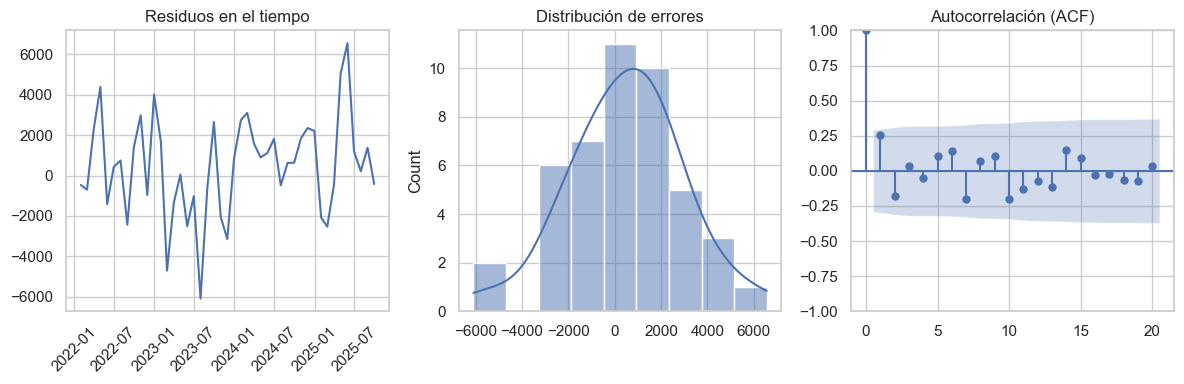

In [333]:
# 1. Calculamos los residuos
residuals = df.loc[predicciones.index, 'reservas_musd'] - predicciones['pred']

# 2. Creamos el lienzo manualmente (3 gráficos)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Gráfico 1: Residuos en el tiempo
axs[0].plot(residuals)
axs[0].set_title("Residuos en el tiempo")
axs[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Distribución (Histograma)
sns.histplot(residuals, kde=True, ax=axs[1])
axs[1].set_title("Distribución de errores")

# Gráfico 3: Autocorrelación (ACF) 
plot_acf(residuals, ax=axs[2], lags=20) 
axs[2].set_title("Autocorrelación (ACF)")

plt.tight_layout()
plt.show()

In [334]:
# Almacenar residuos out-sample en el forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = df.loc[predicciones.index, 'reservas_musd'],
    y_pred = predicciones['pred']
)


In [335]:
pred_niveles  = predicciones['pred']
real_niveles  = df.loc[predicciones.index, 'reservas_musd']

if 'lower_bound' in predicciones.columns:
    lower_niveles = predicciones['lower_bound']
    upper_niveles = predicciones['upper_bound']
# ==============================================================================
fig = go.Figure([
    # 1. Línea de Predicción Puntual
    go.Scatter(
        name = 'Predicción (Nivel)', 
        x    = predicciones.index, 
        y    = pred_niveles, 
        mode = 'lines',
        line = dict(color='blue', width=2)
    ),
    # 2. Línea de Valor Real
    go.Scatter(
        name = 'Valor Real', 
        x    = predicciones.index, 
        y    = real_niveles, 
        mode = 'lines',
        line = dict(color='orange', width=2)
    )
])

# 3. Agregar el sombreado solo si existen los intervalos
if 'lower_bound' in predicciones.columns:
    fig.add_traces([
        go.Scatter(
            name='Intervalo Superior', x=predicciones.index, y=upper_niveles,
            mode='lines', line=dict(width=0), showlegend=False
        ),
        go.Scatter(
            name='Intervalo Inferior', x=predicciones.index, y=lower_niveles,
            mode='lines', line=dict(width=0), fillcolor='rgba(100, 100, 100, 0.2)',
            fill='tonexty', showlegend=False
        )
    ])

# Configuración del diseño (Actualizamos el título)
fig.update_layout(
    title       = '<b>Reservas Totales: Valor Real vs Predicción (Diferenciación Automática)</b>',
    xaxis_title = "Fecha",
    yaxis_title = "Millones de USD (mUSD)",
    width       = 950,
    height      = 500,
    template    = "seaborn",
    hovermode   = "x unified"
)

fig.show()

In [336]:
# 1. Calcular Cobertura en Niveles
# ==============================================================================
cobertura_niveles = calculate_coverage(
    y_true      = real_niveles,
    lower_bound = lower_niveles,
    upper_bound = upper_niveles
)

# 2. Calcular el Ancho Promedio de la Banda (en millones de USD)
# ==============================================================================
ancho_banda = (upper_niveles - lower_niveles).mean()

print(f"Cobertura del intervalo (Niveles): {round(100 * cobertura_niveles, 2)} %")
print(f"Ancho promedio de la banda: {round(ancho_banda, 2)} mUSD")

Cobertura del intervalo (Niveles): 64.44 %
Ancho promedio de la banda: 5656.04 mUSD


In [337]:
# Crear y entrenar el forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    estimator        = LGBMRegressor(**best_params),
    lags             = best_lags,
    window_features  = window_features,
    transformer_y    = StandardScaler(),
    transformer_exog = transformer_exog_sel,
    differentiation  = 1
)
forecaster.fit(
    y    = df.loc[:fin_validacion, 'reservas_musd'],
    exog = df.loc[:fin_validacion, exog_sel]
)


In [338]:
# Extraer importancia de los predictores
# ==============================================================================
importancia = forecaster.get_feature_importances()
importancia.head(10)


,feature,importance
0,lag_1,105
13,riesgo_pais,86
3,roll_mean_3,65
2,lag_12,64
19,riesgo_pais_cambio,50
12,Tasa_Badlar,47
14,VIX,44
15,EMAE_lag1,44
20,riesgo_pais_aceleracion,40
6,IPC_VAR,40


In [339]:
# Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                        y    = df.loc[:fin_validacion, 'reservas_musd'],
                        exog = df.loc[:fin_validacion, exog_sel]
                    )
display(X_train.head(3))
display(y_train.head(3))


,lag_1,lag_2,lag_12,roll_mean_3,brecha_acelerando,EMAE,IPC_VAR,saldo comercial,Precio_Maiz,Precio_Trigo,...,DGS10,riesgo_pais_cambio,riesgo_pais_aceleracion,brecha_cambio,efecto_cosecha,IPC_VAR_lag1,saldo comercial_lag1,Brecha_Usd_lag1,brecha_promedio_3m_lag1,efecto_cosecha_lag1
d,,,,,,,,,,,,,,,,,,,,,
2000-04-30,0.024188,0.082536,-0.070831,-0.006097,0.0,100.811053,-0.001,418.98,80.150576,94.431223,...,6.23,53.08,75.15,0.0,197.103706,-0.005,44.33,0.0,0.0,0.000000
2000-05-31,-0.033366,0.024188,-0.059862,0.024453,0.0,99.580496,-0.004,385.21,84.707274,99.112047,...,6.29,89.01,35.93,0.0,200.870311,-0.001,418.98,0.0,0.0,197.103706
2000-06-30,-0.054738,-0.033366,-0.014561,-0.021305,0.0,99.589101,-0.002,212.47,88.937108,103.366615,...,6.03,-10.99,-100.00,0.0,186.952245,-0.004,385.21,0.0,0.0,200.870311


d
2000-04-30   -0.033366
2000-05-31   -0.054738
2000-06-30    0.054562
Freq: ME, Name: y, dtype: float64

In [340]:
explainer = shap.TreeExplainer(forecaster.estimator)

# Se selecciona una muestra del 50% de los datos para acelerar el cálculo
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)


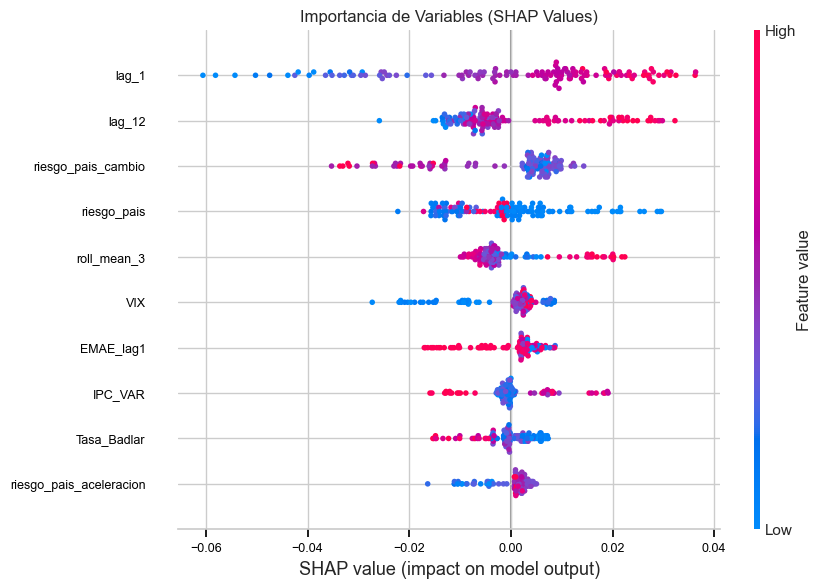

In [341]:
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title("Importancia de Variables (SHAP Values)", fontsize=12)

ax.tick_params(labelsize=9, colors='black') 

plt.gcf().subplots_adjust(left=0.3) 

fig.set_size_inches(10, 6)
plt.show()

In [342]:
predicciones.head(3)


,fold,pred,lower_bound,upper_bound,lag_1,lag_2,lag_12,roll_mean_3,brecha_acelerando,EMAE,...,DGS10,riesgo_pais_cambio,riesgo_pais_aceleracion,brecha_cambio,efecto_cosecha,IPC_VAR_lag1,saldo comercial_lag1,Brecha_Usd_lag1,brecha_promedio_3m_lag1,efecto_cosecha_lag1
2022-01-31,0,39461.121954,34281.429601,44640.814307,-0.133843,-0.033855,0.055443,-0.102798,0.0,148.386672,...,1.79,109.57,144.46,0.023489,0.0,0.038,371.0,0.716557,0.614457,0.0
2022-02-28,1,37985.848870,32806.156517,43165.541223,-0.118372,-0.133843,-0.018890,-0.095357,0.0,150.627497,...,1.83,-75.58,-185.15,-0.018195,0.0,0.039,297.0,0.740046,0.678503,0.0
2022-03-31,2,36264.909743,31085.217390,41444.602096,-0.123940,-0.118372,0.023733,-0.125385,0.0,150.518047,...,2.32,54.67,130.25,-0.025615,0.0,0.047,818.0,0.721851,0.726151,0.0


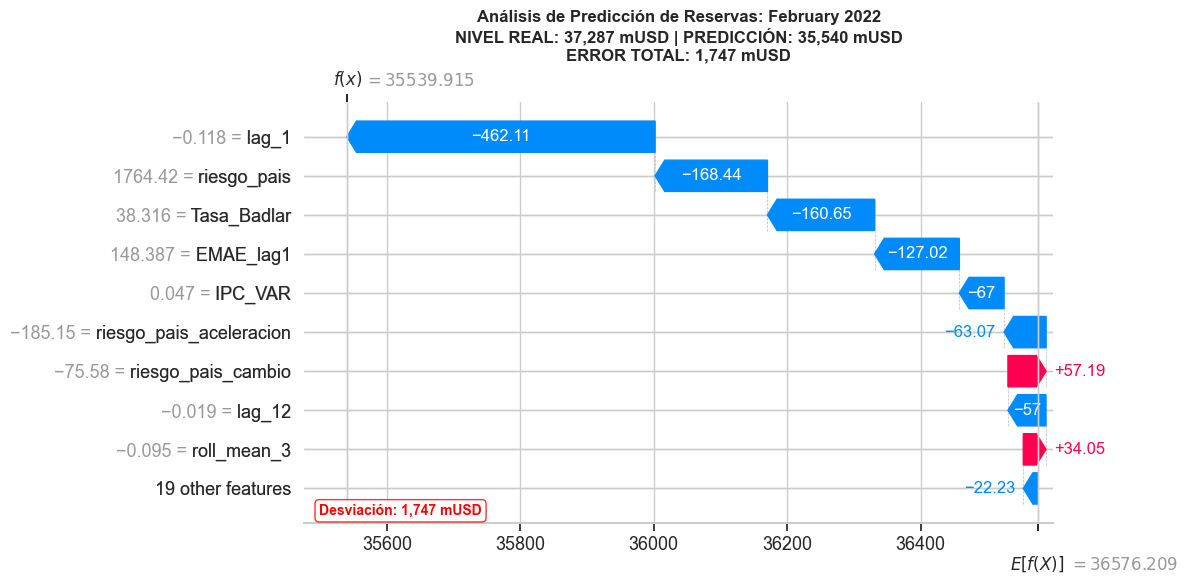


--- Insumos (Valores de entrada) que el modelo 'vio' para 2022-02-28 ---


,lag_1,lag_2,lag_12,roll_mean_3,brecha_acelerando,EMAE,IPC_VAR,saldo comercial,Precio_Maiz,Precio_Trigo,...,DGS10,riesgo_pais_cambio,riesgo_pais_aceleracion,brecha_cambio,efecto_cosecha,IPC_VAR_lag1,saldo comercial_lag1,Brecha_Usd_lag1,brecha_promedio_3m_lag1,efecto_cosecha_lag1
2022-02-28,-0.118372,-0.133843,-0.01889,-0.095357,0.0,150.627497,0.047,818.0,312.682042,347.503227,...,1.83,-75.58,-185.15,-0.018195,0.0,0.039,297.0,0.740046,0.678503,0.0


In [343]:
# 1. Configuración inicial y obtención de datos
# ==============================================================================
fecha_interes = '2022-02-28'
explainer = shap.TreeExplainer(forecaster.estimator)

# Obtenemos la matriz de características que el modelo "ve"
X_train, _ = forecaster.create_train_X_y(y=df['reservas_musd'], exog=df[exog_sel])
iloc_idx = X_train.index.get_loc(fecha_interes)
fecha_exacta = X_train.index[iloc_idx]

# 2. Cálculo y des-escalado de SHAP values (a escala mUSD)
# ==============================================================================
shap_values_single = explainer(X_train.iloc[[iloc_idx]])

# Recuperamos los parámetros del StandardScaler que está dentro del forecaster
scaler = forecaster.transformer_y
mean, std = scaler.mean_[0], scaler.scale_[0]

shap_values_usd = copy.deepcopy(shap_values_single)
shap_values_usd.values = shap_values_single.values * std
shap_values_usd.base_values = shap_values_single.base_values * std + mean

# 3. Métricas directas de Nivel Total
# ==============================================================================
valor_real_niv = df.loc[fecha_exacta, 'reservas_musd']
# La predicción es el valor base + la suma de los impactos de las variables
pred_niv = shap_values_usd.base_values[0] + shap_values_usd.values[0].sum()
error    = valor_real_niv - pred_niv

# 4. Gráfico Waterfall de Niveles
# ==============================================================================
shap.plots.waterfall(shap_values_usd[0], show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(12, 6)

# Título simplificado (ya no hablamos de variaciones)
titulo = (
    f"Análisis de Predicción de Reservas: {fecha_exacta.strftime('%B %Y')}\n"
    f"NIVEL REAL: {valor_real_niv:,.0f} mUSD | PREDICCIÓN: {pred_niv:,.0f} mUSD\n"
    f"ERROR TOTAL: {error:,.0f} mUSD"
)
ax.set_title(titulo, fontsize=12, fontweight='bold', pad=30)

# Anotación visual del error
color_err = 'green' if abs(error) < 500 else 'red'
ax.annotate(f"Desviación: {error:,.0f} mUSD", 
            xy=(0.02, 0.02), xycoords='axes fraction',
            fontsize=10, fontweight='bold', color=color_err,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color_err, alpha=0.8))

plt.tight_layout()
plt.show()

# 5. Tabla de Insumos (Valores originales)
# ==============================================================================
print(f"\n--- Insumos (Valores de entrada) que el modelo 'vio' para {fecha_exacta.date()} ---")
df_insumos = pd.DataFrame(
    shap_values_usd[0].data.reshape(1, -1), 
    columns = X_train.columns,
    index = [fecha_exacta]
)
display(df_insumos)

In [344]:
# Entrenar el forecaster final con lo seleccionado (si no lo hiciste antes)
forecaster.fit(
    y    = df.loc[:fin_validacion, 'reservas_musd'], 
    exog = df.loc[:fin_validacion, exog_sel]
)

# Crear el explainer con el modelo YA ENTRENADO
explainer = shap.TreeExplainer(forecaster.estimator)

In [345]:
# 1. Calculamos las métricas
mse = mean_squared_error(df.loc[predicciones.index, 'reservas_musd'], predicciones['pred'])
rmse = np.sqrt(mse)

# 2. Calculamos el MAPE (error porcentual absoluto medio)
real = df.loc[predicciones.index, 'reservas_musd']
pred = predicciones['pred']
mape = np.mean(np.abs((real - pred) / real)) * 100

# 3. Error relativo (MAE como % de la media de reservas)
media_reservas = real.mean()
mae_porcentaje = (metrica.iloc[0, 0] / media_reservas) * 100

# 4. Tabla actualizada
resumen_tesis = pd.DataFrame({
    'Métrica': ['MAE', 'MAE (%)', 'RMSE', 'MAPE', 'Cobertura (90%)', 'Ancho Promedio Banda'],
    'Valor': [
        f"{metrica.iloc[0, 0]:.2f} mUSD",
        f"{mae_porcentaje:.2f}%",
        f"{rmse:.2f} mUSD", 
        f"{mape:.2f}%",
        f"{100 * cobertura_niveles:.2f}%", 
        f"{(predicciones['upper_bound'] - predicciones['lower_bound']).mean():.2f} mUSD"
    ]
})

display(resumen_tesis)

,Métrica,Valor
0,MAE,1961.74 mUSD
1,MAE (%),5.87%
2,RMSE,2487.04 mUSD
3,MAPE,6.11%
4,Cobertura (90%),64.44%
5,Ancho Promedio Banda,5656.04 mUSD


In [346]:
# REFIT MEJORA PREDICCION A LARGO PLAZO PERO PRINCIPALMENTE PODRIA SER RIESGO DE SOBREAJUSTE PUEDE QUE CON UNA MAYOR CANTIDAD DE DATOS SE PUEDA QUE SE AJUSTE MUCHO A LOS DATOS Y NO SEA GENERALIZABLE

In [347]:
# Test de Ljung-Box sobre los residuos
# Si p-value > 0.05, felicidades: tus residuos son Ruido Blanco (independientes)
res_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Test de Ljung-Box (Ruido Blanco):")
display(res_test)

Test de Ljung-Box (Ruido Blanco):


,lb_stat,lb_pvalue
10,12.109893,0.277769


# No se que tanto suma esto

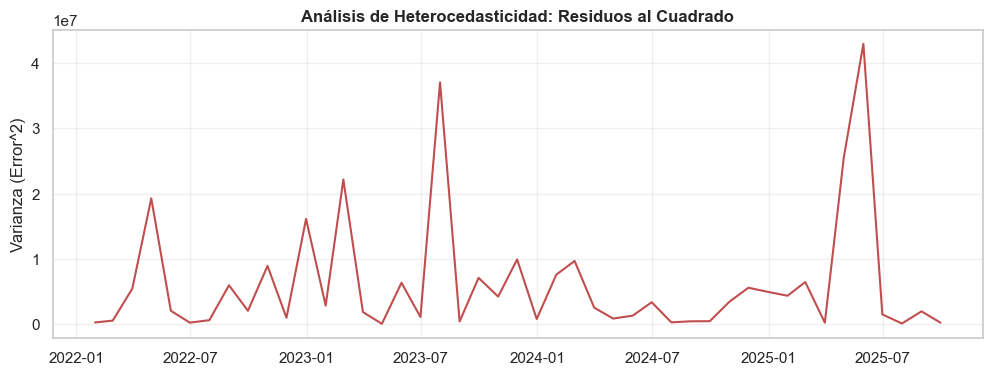

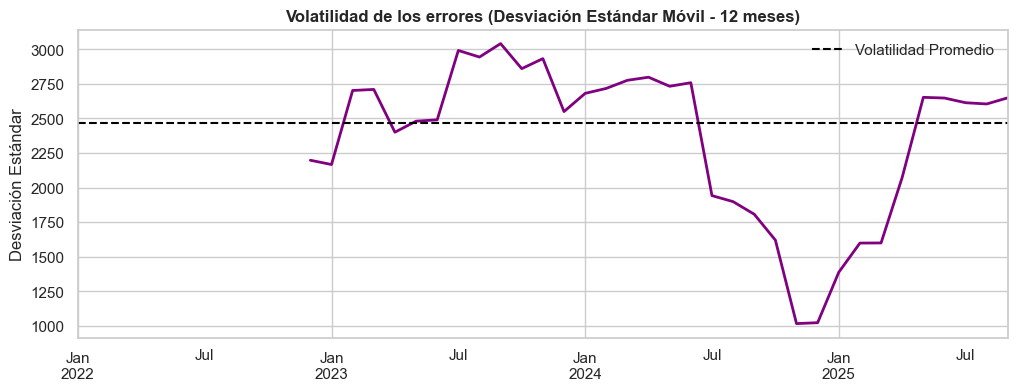

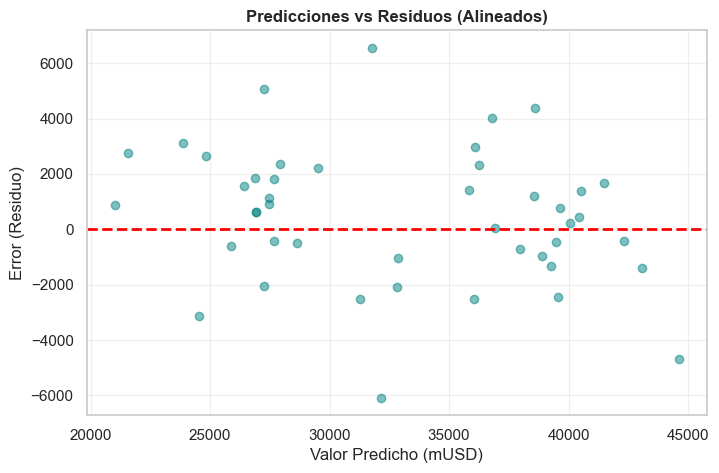

Tamaño predicciones: 45
Tamaño residuos: 45


In [348]:
# 1. Gráfico de Residuos al Cuadrado (Resalta la volatilidad)
# ==============================================================================
plt.figure(figsize=(12, 4))
plt.plot(residuals**2, color='firebrick', alpha=0.8)
plt.title("Análisis de Heterocedasticidad: Residuos al Cuadrado", fontsize=12, fontweight='bold')
plt.ylabel("Varianza (Error^2)")
plt.grid(True, alpha=0.3)
plt.show()

# 2. Volatilidad Móvil (Desviación Estándar de los errores a 12 meses)
# ==============================================================================
plt.figure(figsize=(12, 4))
residuals.rolling(window=12).std().plot(color='purple', linewidth=2)
plt.title("Volatilidad de los errores (Desviación Estándar Móvil - 12 meses)", fontsize=12, fontweight='bold')
plt.ylabel("Desviación Estándar")
plt.axhline(y=residuals.std(), color='black', linestyle='--', label='Volatilidad Promedio')
plt.legend()
plt.show()

# 1. Alineamos las predicciones y los residuos usando el índice común
# ==============================================================================
# Buscamos las fechas que están presentes en ambos objetos
indices_comunes = predicciones.index.intersection(residuals.index)

# Filtramos ambos para que tengan el mismo tamaño y orden
pred_plot = predicciones.loc[indices_comunes, 'pred']
res_plot = residuals.loc[indices_comunes]

# 2. Ahora graficamos sin el error de tamaño
# ==============================================================================
plt.figure(figsize=(8, 5))
plt.scatter(pred_plot, res_plot, alpha=0.5, color='teal')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title("Predicciones vs Residuos (Alineados)", fontsize=12, fontweight='bold')
plt.xlabel("Valor Predicho (mUSD)")
plt.ylabel("Error (Residuo)")
plt.grid(True, alpha=0.3)
plt.show()

# Verificación rápida por consola
print(f"Tamaño predicciones: {len(pred_plot)}")
print(f"Tamaño residuos: {len(res_plot)}")

Análisis de heterocedasticidad mediante residuos al cuadrado. Se observa la presencia de clustering de volatilidad, evidenciado por la agrupación de valores elevados en períodos específicos (mediados de 2022, 2023 y 2025). 
Los residuos exhiben clustering de volatilidad: períodos de errores elevados tienden a agruparse, al igual que los períodos de errores reducidos, indicando que la varianza condicional de los errores no es constante

Volatilidad de los residuos medida como desviación estándar móvil con ventana de 12 meses. La línea punteada representa la volatilidad promedio del período. Se identifican tres regímenes diferenciados: alta volatilidad durante 2023 (errores por encima del promedio), baja volatilidad en 2024-inicios de 2025 (mayor precisión del modelo), y un incremento posterior hacia mediados de 2025. Esta dinámica temporal refuerza la evidencia de heterocedasticidad y justifica la exploración de modelos que capturen la variabilidad condicional de la varianza.

Diagrama de dispersión entre valores predichos y residuos del modelo. Los puntos se distribuyen de manera aleatoria alrededor de la línea de referencia (y=0), sin evidenciar un patrón sistemático de "abanico" u otra estructura. Esto indica que la magnitud de los errores no depende del nivel de la variable predicha, descartando heterocedasticidad asociada al valor de la predicción. No obstante, este resultado no contradice la heterocedasticidad temporal observada en las figuras anteriores.